# Сборный проект —2


##  Прогнозирование уровня удовлетворённости и оттока сотрудников компании "Работа с заботой"

**Описание проекта**

В рамках данного проекта требуется построить модели машинного обучения для прогнозирования двух ключевых показателей: уровня удовлетворённости сотрудников работой в компании и вероятности того, что сотрудник уволится. Для этого используются данные, предоставленные компанией "Работа с заботой", включающие характеристики сотрудников, такие как стаж работы, заработная плата, оценка уровня удовлетворённости и другие. Успешное построение и применение таких моделей позволит бизнесу предсказывать возможные риски оттока сотрудников и принимать своевременные меры по их удержанию, что является важным элементом в управлении персоналом и оптимизации бизнес-процессов.

# Задача 1: предсказание уровня удовлетворённости сотрудника

In [74]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import shap
# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler, 
    LabelEncoder
)

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, OrdinalEncoder

from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# загружаем нужные модели
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score, 
    confusion_matrix, 
    accuracy_score,
    make_scorer,
    roc_auc_score
)

import phik
import warnings
warnings.filterwarnings('ignore')

## Шаг 1. Загрузка данных

Шаг 1. Загрузка данных
Загрузите файлы с данными:
Тренировочная выборка:
train_job_satisfaction_rate.csv
Входные признаки тестовой выборки:
test_features.csv
Целевой признак тестовой выборки:
test_target_job_satisfaction_rate.csv

In [2]:
train_job_satisfacton_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
test_features = pd.read_csv('/datasets/test_features.csv')
test_target_job_satisfaction_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

In [3]:
train_job_satisfacton_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [4]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [5]:
test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [6]:
train_job_satisfacton_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [7]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [8]:
test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


**Описание данных**

* id — уникальный идентификатор сотрудника;
* dept — отдел, в котором работает сотрудник;
* level — уровень занимаемой должности;
* workload — уровень загруженности сотрудника;
* employment_years — длительность работы в компании (в годах);
* last_year_promo — показывает, было ли повышение за последний
год;
* last_year_violations — показывает, нарушал ли сотрудник
трудовой договор за последний год;
* supervisor_evaluation — оценка качества работы сотрудника,
которую дал руководитель;
* salary — ежемесячная зарплата сотрудника;
* job_satisfaction_rate — уровень удовлетворённости сотрудника
работой в компании, целевой признак.

## Шаг 2. Предобработка данных

In [9]:
train_job_satisfacton_rate.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [10]:
test_features.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [11]:
test_target_job_satisfaction_rate.isna().sum()

id                       0
job_satisfaction_rate    0
dtype: int64

In [12]:
train_job_satisfacton_rate

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
...,...,...,...,...,...,...,...,...,...,...
3995,457950,technology,junior,high,2,no,no,3,46800,0.45
3996,957499,sales,junior,medium,2,no,no,4,21600,0.68
3997,533318,sales,middle,low,7,no,no,5,24000,0.76
3998,706868,sales,junior,medium,2,no,no,3,24000,0.48


In [13]:
train_job_satisfacton_rate.duplicated().sum()

0

In [14]:
test_features.duplicated().sum()

0

In [15]:
test_target_job_satisfaction_rate.duplicated().sum()

0

In [16]:
train_job_satisfacton_rate.dept.value_counts()

sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: dept, dtype: int64

In [17]:
train_job_satisfacton_rate['level'] = train_job_satisfacton_rate['level'].replace('sinior', 'senior')
train_job_satisfacton_rate.level.value_counts()

junior    1894
middle    1744
senior     358
Name: level, dtype: int64

In [18]:
train_job_satisfacton_rate.workload.value_counts()

medium    2066
low       1200
high       734
Name: workload, dtype: int64

In [19]:
test_features.dept.value_counts()

sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: dept, dtype: int64

In [20]:
test_features.level.value_counts()

junior    974
middle    854
sinior    171
Name: level, dtype: int64

In [21]:
test_features['level'] = test_features['level'].replace('sinior', 'senior')
test_features.level.value_counts()

junior    974
middle    854
senior    171
Name: level, dtype: int64

In [22]:
test_features.workload.value_counts()

medium    1043
low        593
high       363
             1
Name: workload, dtype: int64

In [23]:
test_features[test_features['dept'] == ' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1699,822186,,middle,medium,3,no,no,4,38400


In [24]:
test_features[test_features['workload'] == ' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800


In [25]:
most_frequent_dept = test_features['dept'].mode()[0]  
test_features['dept'] = test_features['dept'].replace(' ', most_frequent_dept)
most_frequent_dept

'sales'

In [26]:
most_frequent_dept = test_features['workload'].mode()[0]  # Calculate the most frequent department
test_features['workload'] = test_features['workload'].replace(' ', most_frequent_dept)
most_frequent_dept

'medium'

В процессе предобработки данных было выявлено:
* Датасеты train_job_satisfacton_rate и test_features содержат пропуски в колонках dept и level, которые в дальнейшем будут обработаны внутри пайплайна
* Обнаружены пустые строки в колонках dept и workload в датасете test_features, возможно связаные с ошибкой при обработке данных, например, при чтении или загрузке данных из источника. Обработаем их удалив из датасета.

## Шаг 3. Исследовательский анализ данных

### train_job_satisfacton_rate.csv

In [27]:
train_job_satisfacton_rate.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


In [28]:
train_job_satisfacton_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [29]:
(
    train_job_satisfacton_rate[['employment_years','supervisor_evaluation','salary', 'job_satisfaction_rate']]
    .quantile([0.0012, 0.01, .5, .99, .9988]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
0.001200,1.00,1.00,"12,000.00",0.04
0.010000,1.00,1.00,"12,000.00",0.08
0.500000,3.00,4.00,"30,000.00",0.56
0.990000,10.00,5.00,"78,012.00",0.93
0.998800,10.00,5.00,"94,800.00",0.99


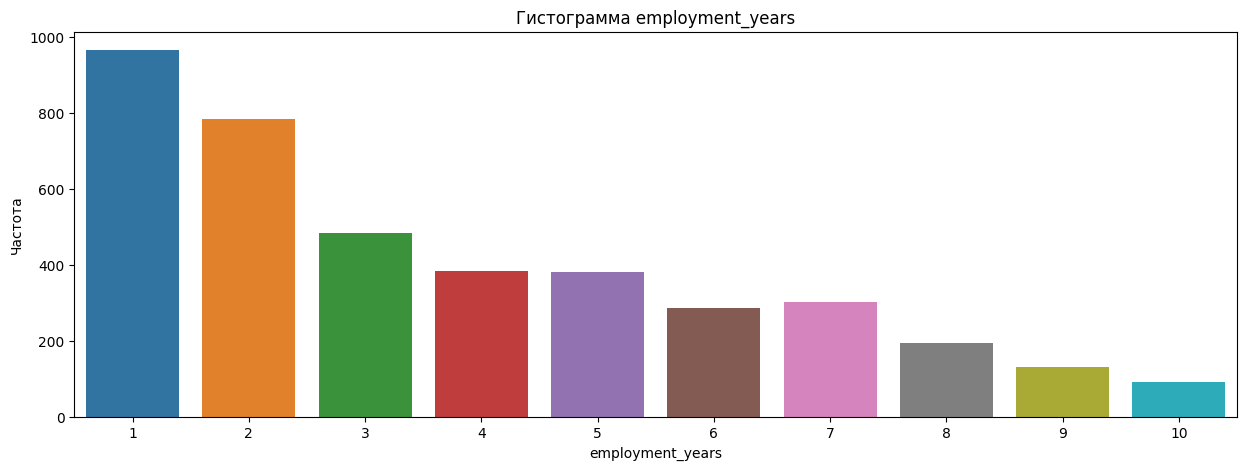

In [30]:
plt.figure(figsize=(15, 5))
sns.countplot(data=train_job_satisfacton_rate, x='employment_years')
plt.title('Гистограмма employment_years')
plt.xlabel('employment_years')
plt.ylabel('Частота')
plt.show()

Гистограмма "employment_years" отображает распределение количества сотрудников по годам трудового стажа. Большинство сотрудников имеют стаж от 1 до 5 лет, с наибольшим количеством на первом году и постепенным уменьшением количества с увеличением стажа до 5 лет. После 5 лет стажа количество сотрудников уменьшается существенно, с наименьшим количеством на 10 летнем стаже.

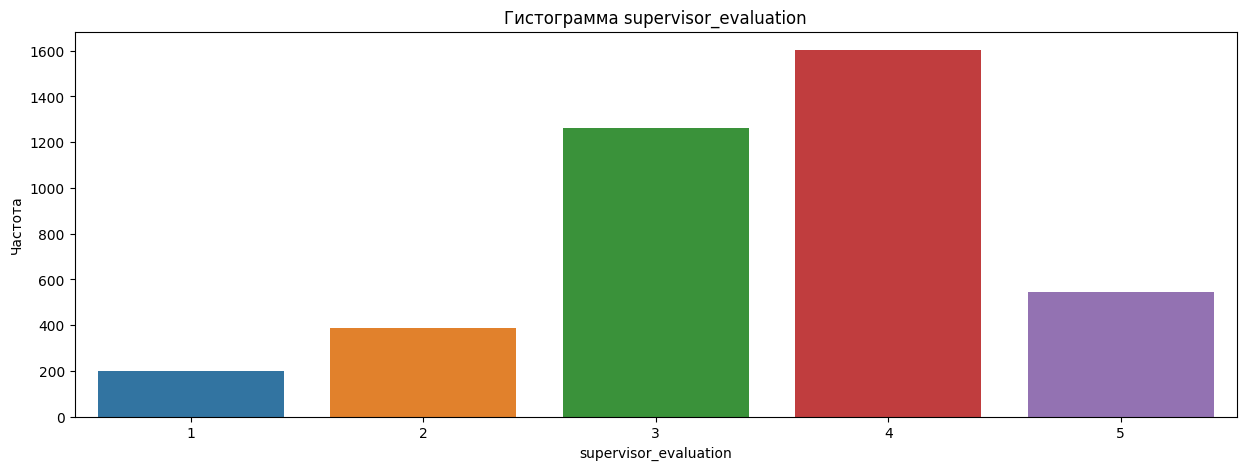

In [31]:
plt.figure(figsize=(15, 5))
sns.countplot(data=train_job_satisfacton_rate, x='supervisor_evaluation')
plt.title('Гистограмма supervisor_evaluation')
plt.xlabel('supervisor_evaluation')
plt.ylabel('Частота')
plt.show()

Гистограмма "supervisor_evaluation" отражает распределение частоты оценок руководителей. Большинство сотрудников получили оценку 4, за ними идут оценки 3 и 5, в то время как оценки 1 и 2 встречаются реже всего.

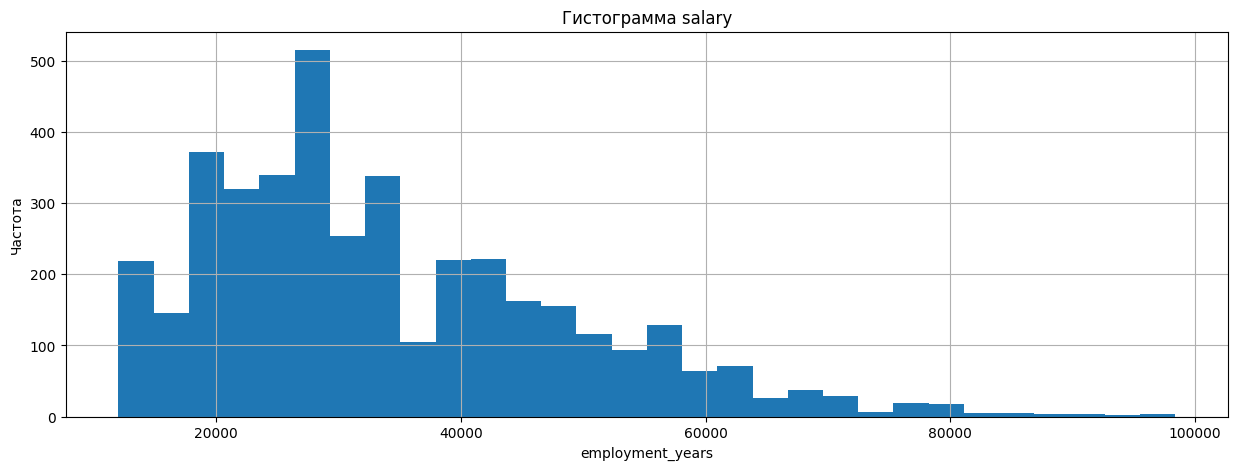

In [32]:
train_job_satisfacton_rate['salary'].hist(bins=30, figsize=(15,5))
plt.title('Гистограмма salary')
plt.xlabel('employment_years')
plt.ylabel('Частота')
plt.show()

Гистограмма "salary" отображает распределение зарплат сотрудников. Средняя зарплата составляет примерно 33926.70, с минимальной зарплатой в 12000 и максимальной в 98400. Большинство зарплат находятся в диапазоне от 22800 до 43200, с наиболее частым значением около 30000.

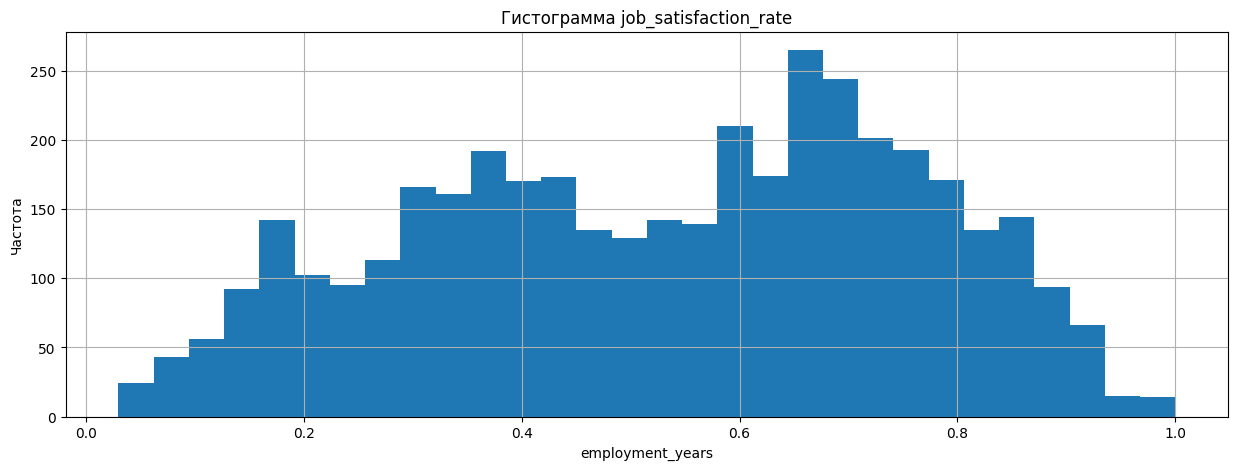

In [33]:
train_job_satisfacton_rate['job_satisfaction_rate'].hist(bins=30, figsize=(15,5))
plt.title('Гистограмма job_satisfaction_rate')
plt.xlabel('employment_years')
plt.ylabel('Частота')
plt.show()

Гистограмма "job_satisfaction_rate" отражает распределение уровня удовлетворенности работой среди сотрудников. Средний уровень удовлетворенности составляет около 0.534, с минимальным значением 0.03 и максимальным - 1. Большинство значений сосредоточено в диапазоне от 0.36 до 0.71, с наиболее частым значением около 0.56.

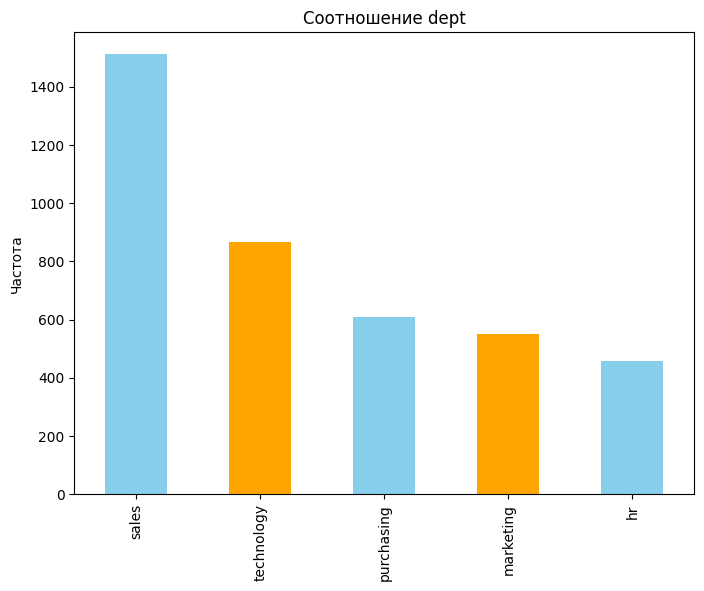

In [34]:
plt.figure(figsize=(8, 6))
train_job_satisfacton_rate['dept'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Cоотношение dept')
plt.ylabel('Частота')
plt.show()

График "Cоотношение dept" показывает количество сотрудников в каждом уровне занятости. Больше всего сотрудников на уровне "sales", затем идут "technology", "purchasing", "marketing" и "hr".

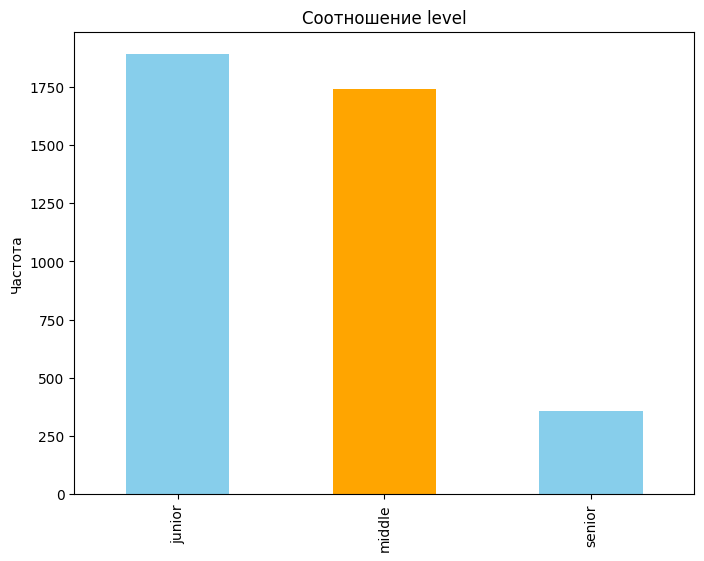

In [35]:
plt.figure(figsize=(8, 6))
train_job_satisfacton_rate['level'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Cоотношение level')
plt.ylabel('Частота')
plt.show()

График "Cоотношение level" отображает количество сотрудников в каждом уровне занятости. Большинство сотрудников находятся на уровне "junior", затем идут "middle" и "senior".


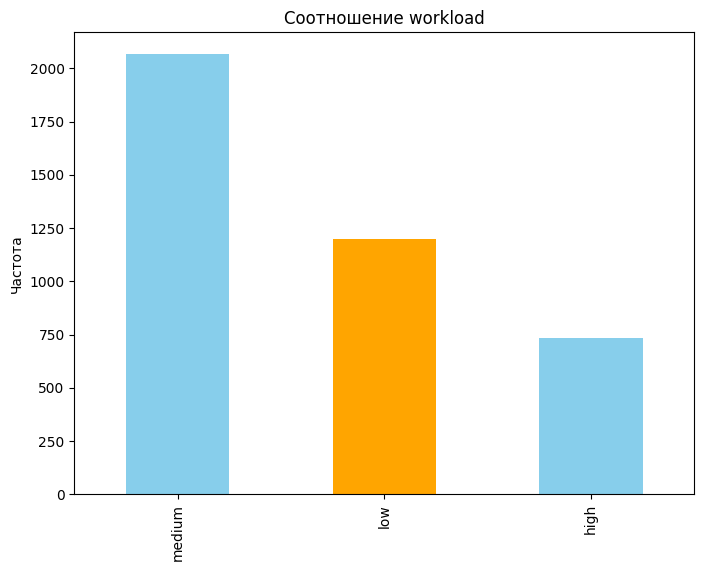

In [36]:
plt.figure(figsize=(8, 6))
train_job_satisfacton_rate['workload'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Cоотношение workload')
plt.ylabel('Частота')
plt.show()

График "Cоотношение workload" на тренировочной наборе данных отражает количество сотрудников в каждом уровне нагрузки. Большинство сотрудников имеют среднюю нагрузку (medium), за ними следуют низкая нагрузка (low) и высокая нагрузка (high)

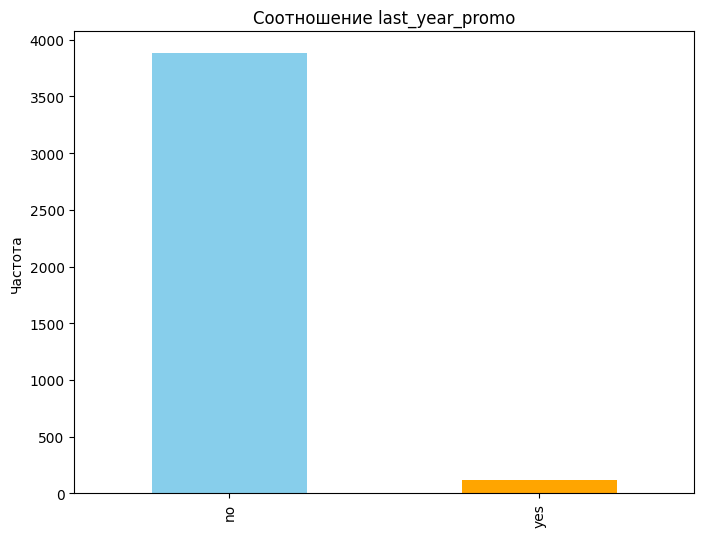

In [37]:
plt.figure(figsize=(8, 6))
train_job_satisfacton_rate['last_year_promo'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Cоотношение last_year_promo')
plt.ylabel('Частота')
plt.show()

График "Cоотношение last_year_promo" показывает количество сотрудников, получивших продвижение в прошлом году. Большинство сотрудников не получили продвижения (3880 человек), в то время как только 120 человек получили продвижение.|

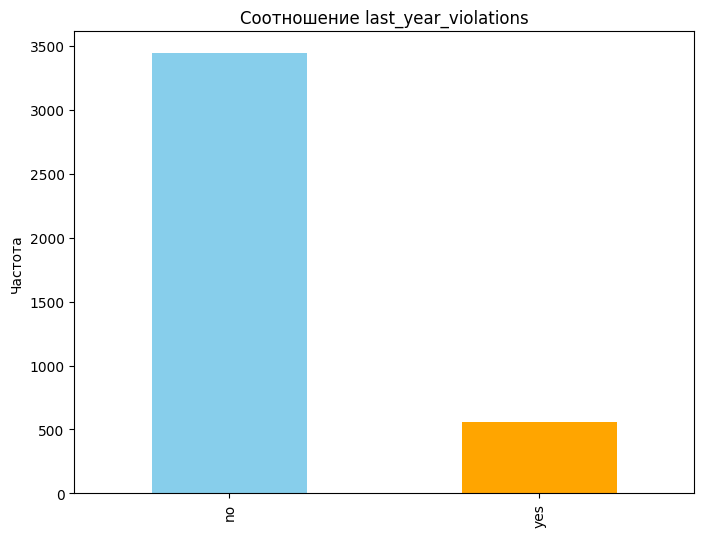

In [38]:
plt.figure(figsize=(8, 6))
train_job_satisfacton_rate['last_year_violations'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Cоотношение last_year_violations')
plt.ylabel('Частота')
plt.show()

График "Cоотношение last_year_violations" показывает количество сотрудников, имевших нарушения в прошлом году. Большинство сотрудников (3441 человек) не имели нарушений, в то время как 559 человек имели нарушения.

## test_features.csv

In [39]:
test_features.describe()

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


In [40]:
(
    test_features[['employment_years','supervisor_evaluation','salary']]
    .quantile([0.0012, 0.01, .5, .99, .9988]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

,employment_years,supervisor_evaluation,salary
0.001200,1.00,1.00,"12,000.00"
0.010000,1.00,1.00,"12,000.00"
0.500000,3.00,4.00,"30,000.00"
0.990000,10.00,5.00,"81,600.00"
0.998800,10.00,5.00,"94,800.00"


In [41]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


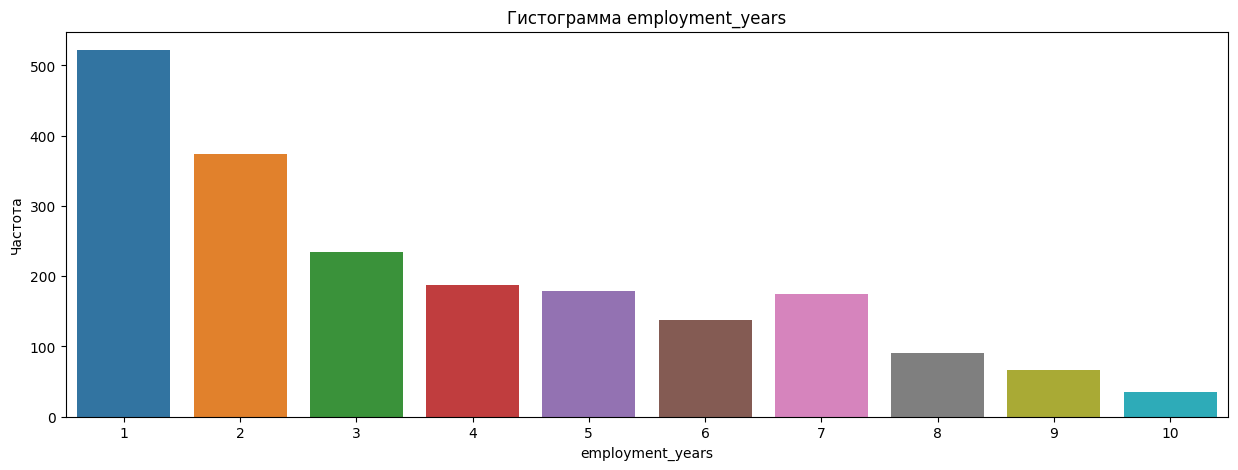

In [42]:
plt.figure(figsize=(15, 5))
sns.countplot(data=test_features, x='employment_years')
plt.title('Гистограмма employment_years')
plt.xlabel('employment_years')
plt.ylabel('Частота')
plt.show()

Гистограмма "employment_years" отражает распределение количества сотрудников по годам трудового стажа на тестовом наборе данных. Большинство сотрудников имеют стаж от 1 до 5 лет, с наибольшим количеством на первом году и постепенным уменьшением количества с увеличением стажа до 5 лет. После 5 лет стажа количество сотрудников уменьшается, с наименьшим количеством на 10-летнем стаже.

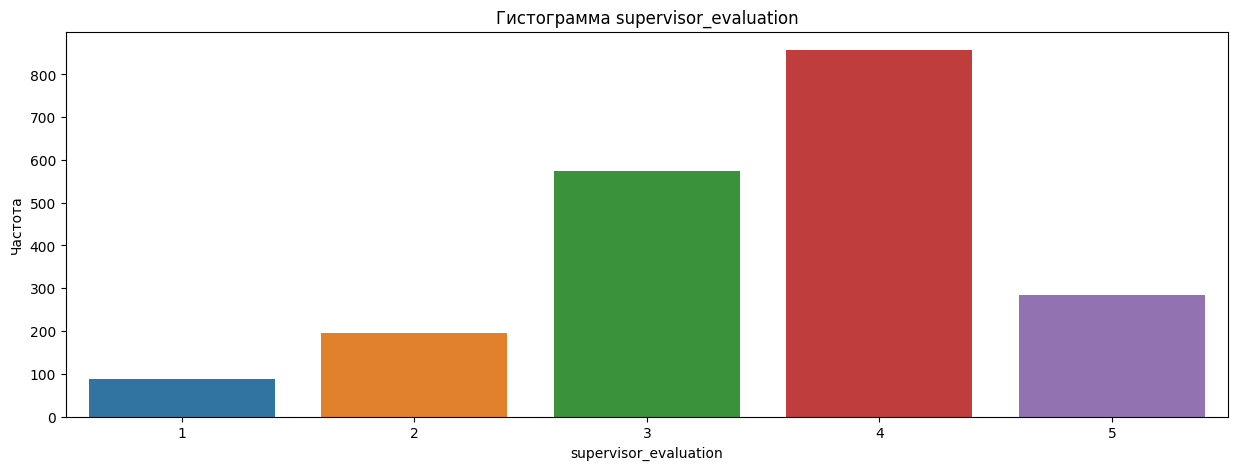

In [43]:
plt.figure(figsize=(15, 5))
sns.countplot(data=test_features, x='supervisor_evaluation')
plt.title('Гистограмма supervisor_evaluation')
plt.xlabel('supervisor_evaluation')
plt.ylabel('Частота')
plt.show()

Гистограмма "supervisor_evaluation" на тестовом наборе данных отражает распределение частоты оценок руководителей среди сотрудников. Большинство сотрудников получили оценку 4, за ними идут оценки 3 и 5, в то время как оценки 1 и 2 встречаются реже всего.

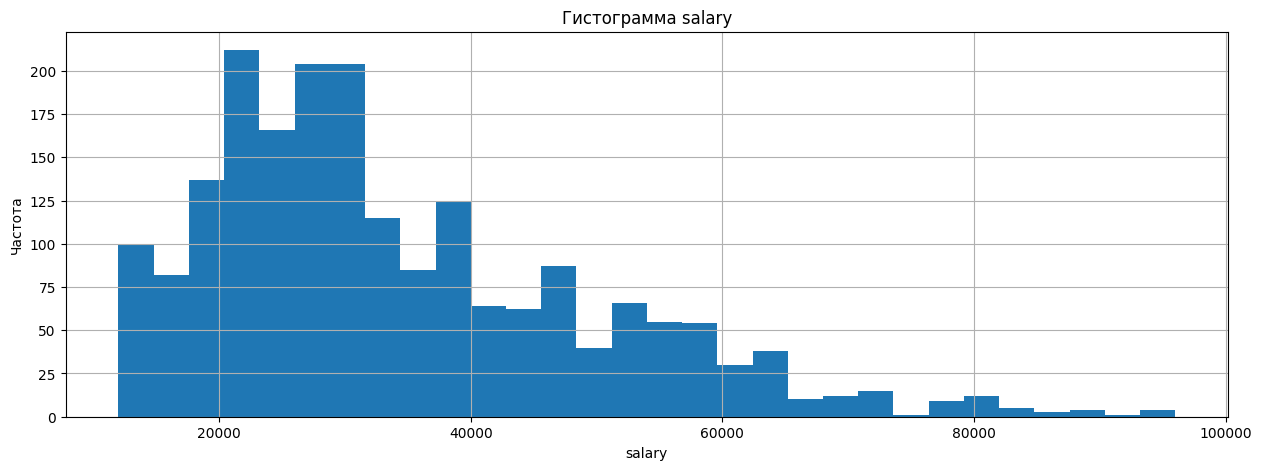

In [44]:
test_features['salary'].hist(bins=30, figsize=(15,5))
plt.title('Гистограмма salary')
plt.xlabel('salary')
plt.ylabel('Частота')
plt.show()

Гистограмма "salary" на тестовом наборе данных отражает распределение зарплат сотрудников. Средняя зарплата составляет около 34066.80, с минимальной зарплатой в 12000 и максимальной в 96000. Большинство зарплат находятся в диапазоне от 22800 до 43200, с наиболее частым значением около 30000.

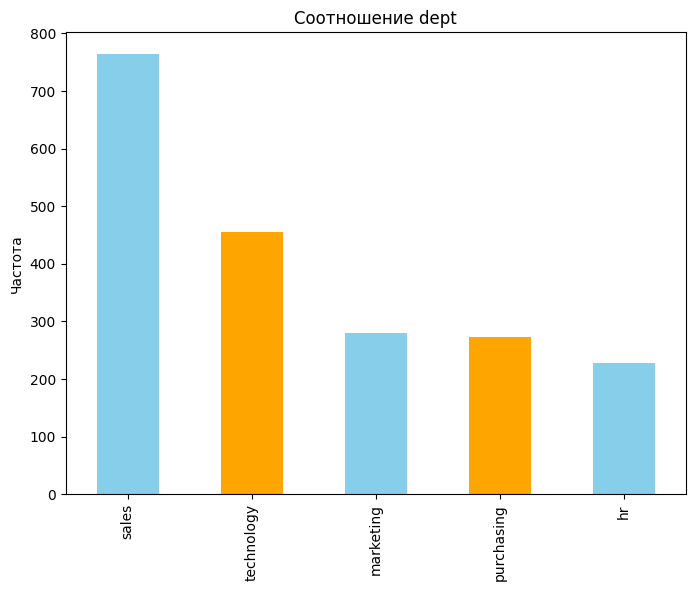

In [45]:
plt.figure(figsize=(8, 6))
test_features['dept'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Cоотношение dept')
plt.ylabel('Частота')
plt.show()

График "Cоотношение dept" на тестовом наборе данных показывает количество сотрудников в каждом отделе. Больше всего сотрудников в отделе "sales", затем идут "technology", "marketing", "purchasing" и "hr".

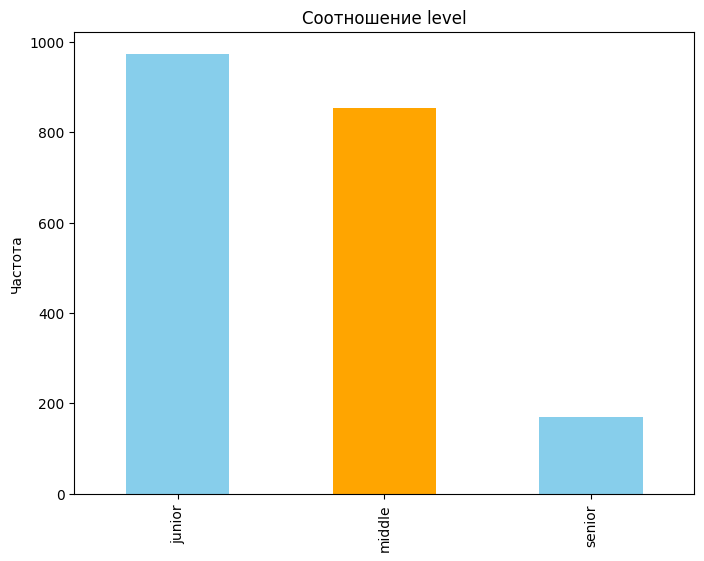

In [46]:
plt.figure(figsize=(8, 6))
test_features['level'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Cоотношение level')
plt.ylabel('Частота')
plt.show()

График "Cоотношение level" на тестовом наборе данных отображает количество сотрудников в каждом уровне занятости. Большинство сотрудников находятся на уровне "junior", затем идут "middle" и "senior".

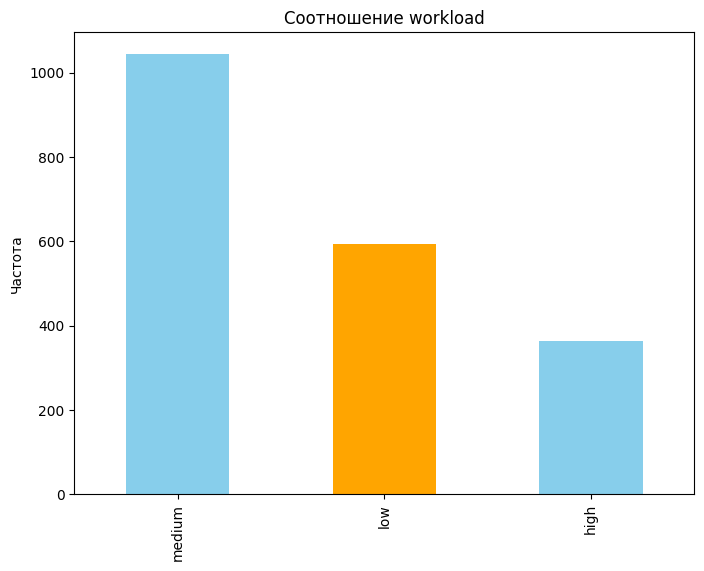

In [47]:
plt.figure(figsize=(8, 6))
test_features['workload'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Cоотношение workload')
plt.ylabel('Частота')
plt.show()

График "Cоотношение workload" на тестовом наборе данных отражает количество сотрудников в каждом уровне нагрузки. Большинство сотрудников имеют среднюю нагрузку (medium), за ними следуют низкая нагрузка (low) и высокая нагрузка (high).

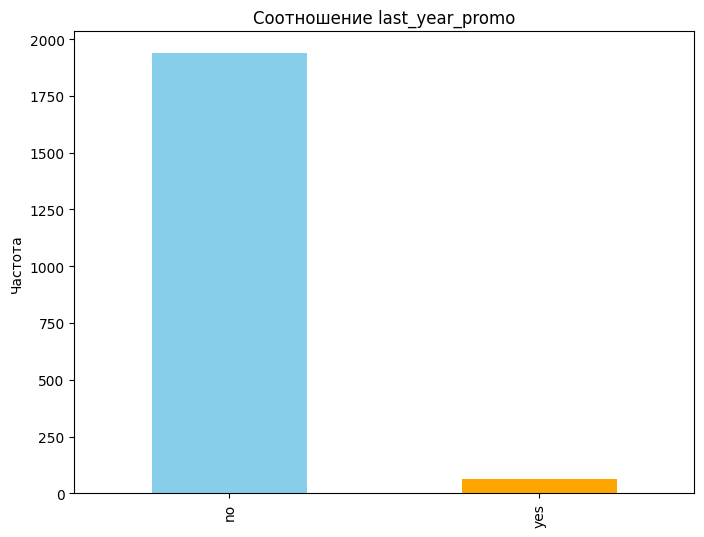

In [48]:
plt.figure(figsize=(8, 6))
test_features['last_year_promo'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Cоотношение last_year_promo')
plt.ylabel('Частота')
plt.show()

График "Cоотношение last_year_promo" на тестовом наборе данных отражает количество сотрудников, получивших продвижение в прошлом году. Большинство сотрудников не получили продвижения (1937 человек), в то время как только 63 человека получили продвижение.

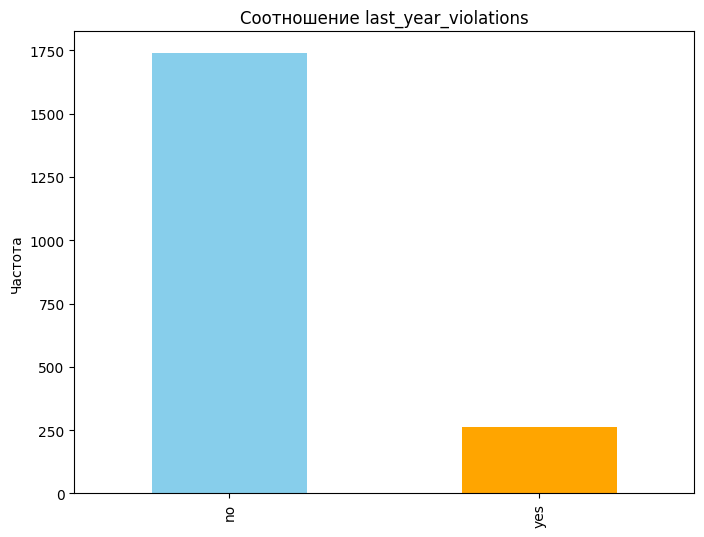

In [49]:
plt.figure(figsize=(8, 6))
test_features['last_year_violations'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Cоотношение last_year_violations')
plt.ylabel('Частота')
plt.show()

График "Cоотношение last_year_violations" на тестовом наборе данных отображает количество сотрудников с нарушениями в прошлом году. Большинство сотрудников не имели нарушений (1738 человек), в то время как 262 человека имели нарушения.

## test_target_job_satisfaction_rate.csv

In [50]:
test_target_job_satisfaction_rate.describe()

,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


In [51]:
(
    test_target_job_satisfaction_rate[['job_satisfaction_rate']]
    .quantile([0.0012, 0.01, .5, .99, .9988]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

,job_satisfaction_rate
0.001200,0.05
0.010000,0.09
0.500000,0.58
0.990000,0.94
0.998800,1.00


In [52]:
test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


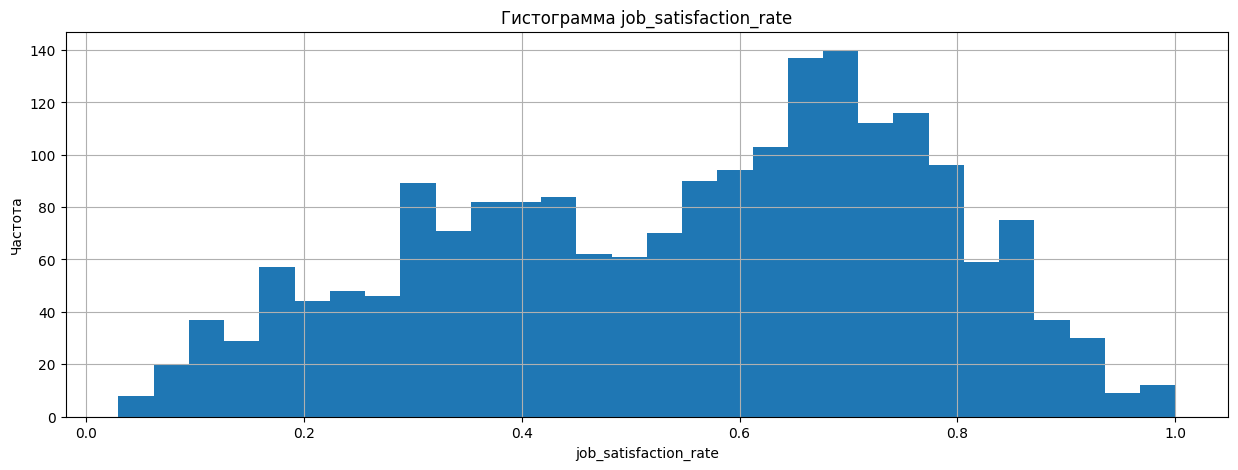

In [53]:
test_target_job_satisfaction_rate['job_satisfaction_rate'].hist(bins=30, figsize=(15,5))
plt.title('Гистограмма job_satisfaction_rate')
plt.xlabel('job_satisfaction_rate')
plt.ylabel('Частота')
plt.show()

Гистограмма "job_satisfaction_rate" на тестовом наборе данных отражает распределение уровня удовлетворенности работой среди сотрудников. Средний уровень удовлетворенности составляет около 0.549, с минимальным значением 0.03 и максимальным - 1. Большинство значений сосредоточено в диапазоне от 0.38 до 0.72, с наиболее частым значением около 0.58.

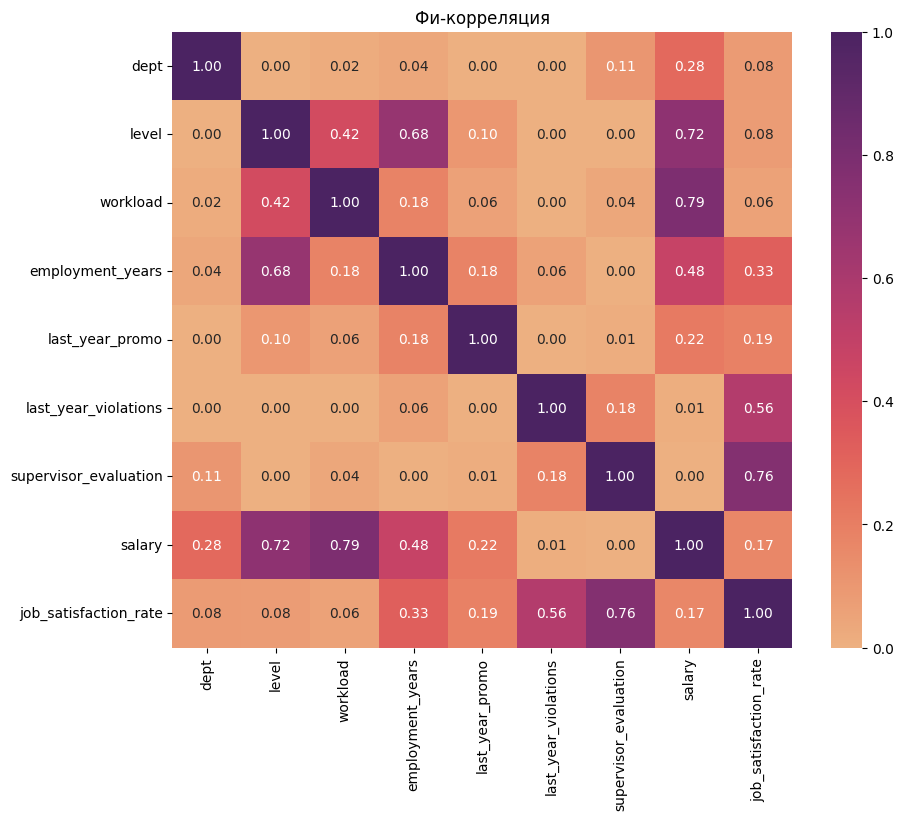

In [54]:
train_job_satisfacton_rate_sub = train_job_satisfacton_rate.drop('id', axis=1)
numerical_col_names = ['salary', 'job_satisfaction_rate']
categorical_corr = train_job_satisfacton_rate_sub.phik_matrix(interval_cols=numerical_col_names)
plt.figure(figsize=(10, 8)) 
sns.heatmap(categorical_corr, annot=True, cmap='flare', fmt=".2f")
plt.title('Фи-корреляция')
plt.show()

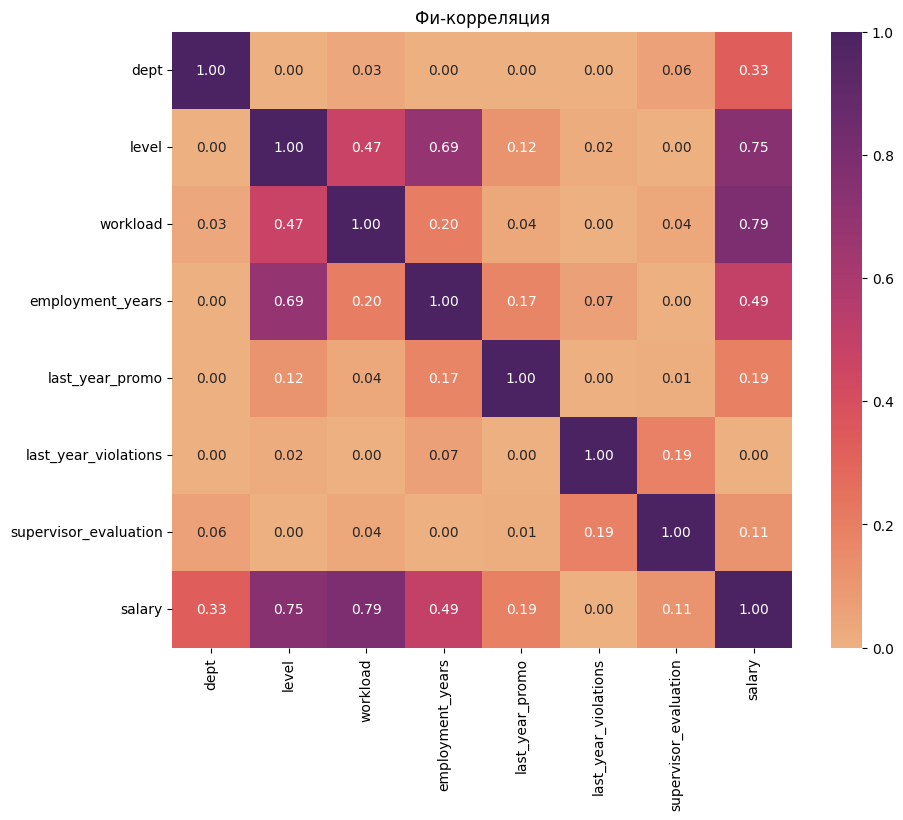

In [55]:
test_features_sub = test_features.drop('id', axis=1)
numerical_col_names = ['salary']
categorical_corr = test_features_sub.phik_matrix(interval_cols=numerical_col_names)
plt.figure(figsize=(10, 8)) 
sns.heatmap(categorical_corr, annot=True, cmap='flare', fmt=".2f")
plt.title('Фи-корреляция')
plt.show()

По коэффициентам корреляции между признаками и целевой переменной (уровень удовлетворенности работой) можно сделать следующие выводы:

1. **Оценка руководителя (supervisor_evaluation)**: Наблюдается сильная положительная корреляция (0.76). Это свидетельствует о том, что высокая оценка со стороны руководства обычно сопровождается более высоким уровнем удовлетворенности работой у сотрудника. Этот результат подтверждает предположение о важности роли руководства в формировании и поддержании удовлетворенности персонала.

2. **Количество нарушений в прошлом году (last_year_violations)**: Наблюдается умеренная положительная корреляция (0.56). Это говорит о том, что сотрудники, имевшие меньше нарушений в прошлом году, обычно имеют более высокий уровень удовлетворенности работой. Этот результат также подтверждает влияние прошлых опытов и событий на текущую удовлетворенность работой.

3. **Стаж работы в компании (employment_years)**: Обнаружена умеренная положительная корреляция (0.33). Это указывает на то, что уровень удовлетворенности работой склонен расти с увеличением стажа работы сотрудника в компании. Этот вывод подтверждает предположение о том, что с ростом стажа у сотрудников возникают более благоприятные условия для удовлетворенности и уверенности в своей работе.

Мультиколлинеарности, при которой коэффициенты корреляции между признаками больше 0.9, не наблюдается.

## Шаг 4. Подготовка данных

In [56]:
X_train = train_job_satisfacton_rate.drop('id', axis=1)

In [57]:
X_train.duplicated().sum() 

245

In [58]:
X_train = X_train.drop_duplicates()

In [59]:
X_train.duplicated().sum() 

0

In [60]:
y_train = X_train['job_satisfaction_rate']

In [61]:
X_train = X_train.drop('job_satisfaction_rate', axis=1)

In [63]:
X_test_ids = test_features['id'].values
y_test_ids = test_target_job_satisfaction_rate['id'].values

# Check if IDs in X_test match with IDs in y_test
if np.array_equal(X_test_ids, y_test_ids):
    print('IDs in X_test and y_test match.')
else:
    print('IDs in X_test and y_test do not match. Check the order of observations.')

IDs in X_test and y_test do not match. Check the order of observations.


In [64]:
test_features_sorted = test_features.sort_values(by='id')
test_target_job_satisfaction_rate_sorted = test_target_job_satisfaction_rate.sort_values(by='id')

X_test = test_features_sorted.drop('id', axis=1)
y_test = test_target_job_satisfaction_rate_sorted['job_satisfaction_rate']
X_test_ids = test_features_sorted['id'].values
y_test_ids = test_target_job_satisfaction_rate_sorted['id'].values

if np.array_equal(X_test_ids, y_test_ids):
    print('IDs in X_test and y_test match after sorting.')
else:
    print('IDs in X_test and y_test still do not match after sorting.')

IDs in X_test and y_test match after sorting.


In [65]:
X_train.shape, X_test.shape

((3755, 8), (2000, 8))

In [66]:
num_columns = ['employment_years', 'salary', 'supervisor_evaluation']
ord_columns = ['level', 'workload', 'last_year_promo', 'last_year_violations']
ohe_columns = ['dept']

In [67]:
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
])

In [68]:
num_pipe = Pipeline(
        [
            ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
            ('num', RobustScaler())
        ]
)

In [69]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'],
                    ['no', 'yes'],
                    ['no', 'yes']
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

Можно ли так делать?

        
        num_pipe = Pipeline(
            [
                ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
                ('num', RobustScaler())
            ]
        )

In [70]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

In [71]:
data_preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['dept']),
                                ('ord',
                                 Pipeline(steps=[('simpleImputer_before_ord',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord',
                                                  OrdinalEncoder(categories...
                                                                              'yes'],
                                                                             ['no',
                                                                              'yes']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=nan)),
                                                 ('simpleImputer_after_ord',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['level', 'workload', 'last_year_promo',
                                  'last_year_violations']),
                                ('num',
                                 Pipeline(steps=[('simpleImputer_num',
                                                  SimpleImputer()),
                                                 ('num', RobustScaler())]),
                                 ['employment_years', 'salary',
                                  'supervisor_evaluation'])])

In [72]:
RANDOM_STATE = 42
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

In [75]:
param_grid = [
    
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__splitter': ['best', 'random'],
        'models__max_depth': range(2, 15),
        'models__max_features': ["log2", "sqrt", None], 
        'models__min_samples_leaf': range(2, 15),
        'models__min_weight_fraction_leaf':range(0, 1),
        'models__max_leaf_nodes': range(2, 100),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
    
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
        'preprocessor__ohe': [OneHotEncoder()] 
    },
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': range(100, 300),
        'models__max_depth': [10, 20, 30, None],
        'models__min_samples_split': range(2, 10),
        'models__min_samples_leaf': [1, 2, 4],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },

    {
        'models': [GradientBoostingRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': range(100, 300),
        'models__learning_rate': [0.1, 0.05, 0.01],
        'models__max_depth': range(3, 10),
        'models__min_samples_split': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },

    {
        'models': [XGBRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 200, 300],
        'models__learning_rate': [0.05, 0.1, 0.2],
        'models__max_depth': [3, 4, 5],
        'models__min_child_weight': [1, 3, 5],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },

    {
        'models': [SVR()],
        'models__C': range(1, 5),
        'models__probability': [True],
        'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'models__gamma': ['scale', 'auto'],
        'models__epsilon': [0.1, 0.2, 0.3], 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
        'preprocessor__ohe': [OneHotEncoder(), OrdinalEncoder()]  
    },
]

На этом шаге была проведена подготовка данных для моделирования машинного обучения. Вначале были удалены дубликаты из тренировочного набора данных, затем идентификаторы из тестового набора данных были проверены на соответствие с целевым набором данных. После этого данные были отсортированы по идентификаторам для сопоставимости с целевым набором данных.

Для подготовки данных к моделированию была использована конвейерная обработка данных (Pipeline). В конвейере были применены различные методы предварительной обработки данных, такие как заполнение пропущенных значений, кодирование категориальных признаков и масштабирование числовых признаков. Конвейер был настроен для каждого типа признаков (категориальные, порядковые и числовые) с использованием соответствующих методов обработки.

Для моделирования была использована конечная конвейерная модель (pipe_final), включающая в себя предварительную обработку данных и модель логистической регрессии. Для настройки гиперпараметров моделей был определен param_grid, включающий варианты настройки для моделей DecisionTreeRegressor, LinearRegression и SVR.

## Шаг 5. Обучение моделей

In [76]:
def smape(actual, predicted) -> float:
    return (np.mean(2.0 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))) * 100


smape_score = make_scorer(smape, greater_is_better=False)

In [77]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring= smape_score,
    error_score='raise',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=100
)

randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', np.abs(randomized_search.best_score_))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                  

In [78]:
y_test_pred = randomized_search.predict(X_test)

smape_test = smape(y_test, y_test_pred)
print(f'Метрика SMAPE на тестовой выборке: {smape_test}')

Метрика SMAPE на тестовой выборке: 10.964241079981269


## Шаг 6. Оформление выводов

По результатам построения и оценки модели на тестовой выборке мы получили значение метрики SMAPE, равное приблизительно 10.96. SMAPE - это метрика, используемая для измерения точности прогнозов в задачах временных рядов, и чем ниже значение, тем лучше.

Лучшая модель, определенная после выполнения процесса подбора параметров с использованием RandomizedSearchCV, является Pipeline, состоящий из предварительной обработки данных с помощью ColumnTransformer, а затем применения ансамблевого метода градиентного бустинга (GradientBoostingRegressor). Параметры лучшей модели включают в себя максимальную глубину деревьев (max_depth=5) и количество деревьев (n_estimators=272).

Эта модель имеет низкое значение метрики SMAPE, что указывает на хорошее качество прогнозов уровня удовлетворенности работой сотрудников.

Таким образом, можно сделать вывод о том, что данная модель может быть эффективно использована для прогнозирования уровня удовлетворенности работой сотрудников на основе имеющихся данных.

# Часть вторая: предсказание увольнения сотрудника из компании

## Шаг 1. Загрузка данных

In [79]:
train_quit = pd.read_csv('/datasets/train_quit.csv')
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')

In [80]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [81]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [82]:
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [83]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Описание данных:
1. **train_quit** (Тренировочный набор данных для атрибуции ухода сотрудников):
   - 4000 записей, 10 столбцов.
   - Столбцы: 'id' (идентификатор сотрудника), 'dept' (отдел), 'level' (уровень), 'workload' (нагрузка), 'employment_years' (стаж работы в годах), 'last_year_promo' (последнее повышение в прошлом году), 'last_year_violations' (нарушения в прошлом году), 'supervisor_evaluation' (оценка руководителя), 'salary' (заработная плата), 'quit' (ушел ли сотрудник).
   - Типы данных: int64 для числовых столбцов и object для категориальных.

2. **test_features** (Тестовый набор данных для атрибуции ухода сотрудников):
   - 2000 записей, 9 столбцов.
   - Столбцы: 'id', 'dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'salary'.
   - Типы данных: int64 для числовых столбцов и object для категориальных.

3. **test_target_quit** (Целевой набор данных для атрибуции ухода сотрудников):
   - 2000 записей, 2 столбца.
   - Столбцы: 'id' (идентификатор сотрудника), 'quit' (ушел ли сотрудник).
   - Типы данных: int64 для идентификатора и object для статуса ухода.

Данные содержат информацию о различных аспектах работы сотрудников, включая отдел, уровень, нагрузку, стаж, оценку руководителя, заработную плату и статус ухода.

## Шаг 2. Предобработка данных

In [84]:
train_quit.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

In [85]:
test_target_quit.isna().sum()

id      0
quit    0
dtype: int64

In [86]:
train_quit.duplicated().sum()


0

In [87]:
test_target_quit.duplicated().sum()

0

In [88]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [89]:
train_quit.quit.value_counts()

no     2872
yes    1128
Name: quit, dtype: int64

In [90]:
train_quit.level.value_counts()

junior    1949
middle    1694
sinior     357
Name: level, dtype: int64

In [91]:
train_quit.workload.value_counts()

medium    2118
low       1208
high       674
Name: workload, dtype: int64

В шаге предобработки данных не было выявлено никаких аномалий в данных. Данные не содержат дубликатов и пропусков.

## Шаг 3. Исследовательский анализ данных

Шаг 3. Исследовательский анализ данных

3.1. Проведите исследовательский анализ данных.

3.2. Составьте портрет «уволившегося сотрудника». Например, можно узнать, в каком отделе с большей вероятностью работает уволившийся сотрудник и какой у него уровень загруженности. Также можно сравнить среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.

3.3. Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверьте это утверждение: визуализируйте и сравните распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. Используйте данные с обоими целевыми признаками тестовой выборки.

In [92]:
train_quit.describe()

,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


In [93]:
(
    train_quit[['id', 'employment_years', 'supervisor_evaluation', 'salary']]
    .quantile([0.0012, 0.01, .5, .99, .9988]) 
    .style.format("{:,.2f}")
)

,id,employment_years,supervisor_evaluation,salary
0.001200,"100,946.67",1.00,1.00,"12,000.00"
0.010000,"108,079.88",1.00,1.00,"12,000.00"
0.500000,"546,673.00",3.00,4.00,"30,000.00"
0.990000,"991,329.44",10.00,5.00,"79,200.00"
0.998800,"998,362.83",10.00,5.00,"92,882.88"


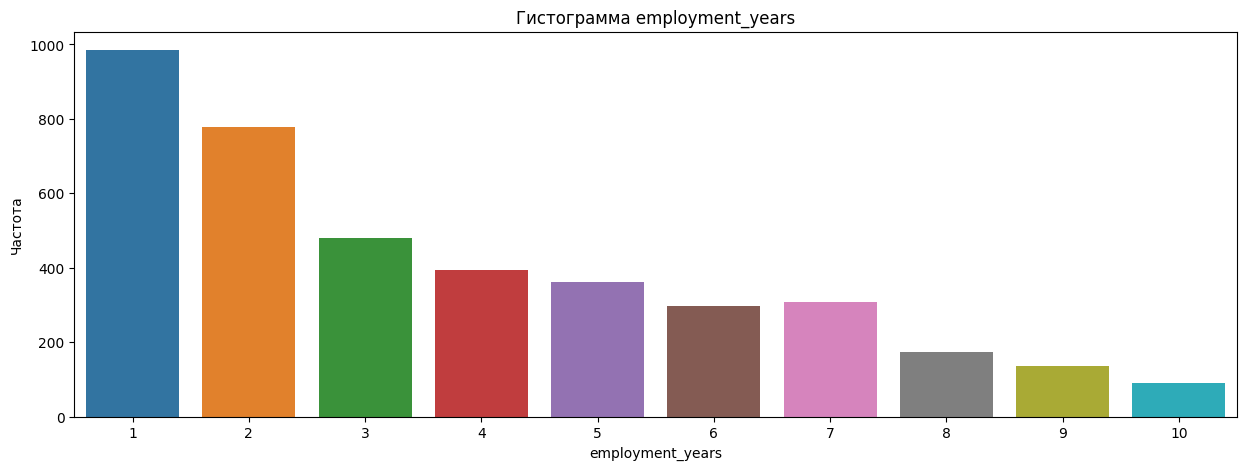

In [94]:
plt.figure(figsize=(15, 5))
sns.countplot(data=train_quit, x='employment_years')
plt.title('Гистограмма employment_years')
plt.xlabel('employment_years')
plt.ylabel('Частота')
plt.show()

График количества сотрудников по годам стажа работы в компании показывают следующее: самое большое количество сотрудников имеют стаж от 1 до 3 лет. Есть значительное количество сотрудников с более продолжительным стажем, например, от 4 до 6 лет. Сотрудники с очень коротким или очень длительным стажем (менее 1 года или более 9 лет) составляют меньшую часть общего числа.

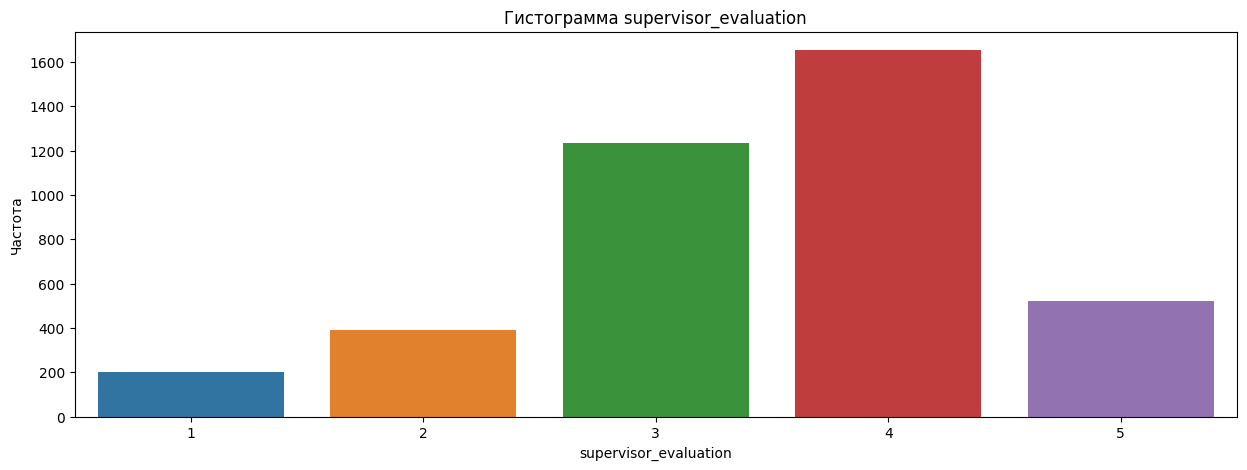

In [95]:
plt.figure(figsize=(15, 5))
sns.countplot(data=train_quit, x='supervisor_evaluation')
plt.title('Гистограмма supervisor_evaluation')
plt.xlabel('supervisor_evaluation')
plt.ylabel('Частота')
plt.show()

Гистограмма и таблица подсчета оценок сотрудников от руководителей показывают следующее: большинство сотрудников получили оценку 4 или 3 от своих руководителей. Оценки 5 и 2 также встречаются, но в меньшей степени. Наименьшее количество сотрудников получили оценки 1 от своих руководителей.

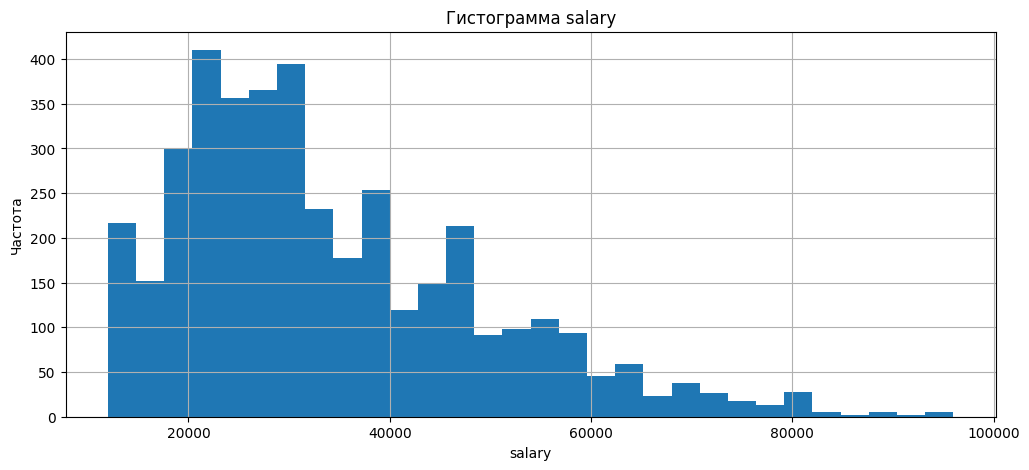

In [96]:
train_quit['salary'].hist(bins=30, figsize=(12,5))
plt.title('Гистограмма salary')
plt.xlabel('salary')
plt.ylabel('Частота')
plt.show()

Гистограмма распределения зарплат сотрудников показывает, что большинство сотрудников имеют зарплату в диапазоне от 22,800 до 43,200 долларов в год. Средняя зарплата составляет примерно 33,805 долларов в год, со стандартным отклонением около 15,152 долларов. Минимальная зарплата в данных равна 12,000 долларов, а максимальная достигает 96,000 долларов.

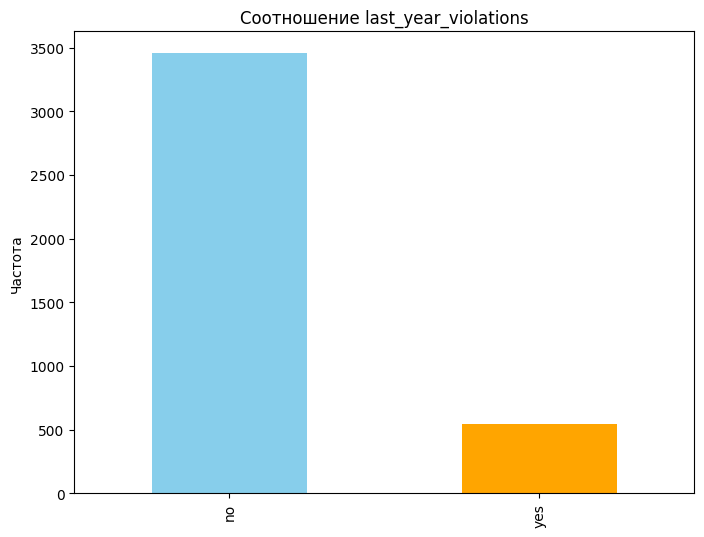

In [97]:
plt.figure(figsize=(8,6))
train_quit['last_year_violations'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Cоотношение last_year_violations')
plt.ylabel('Частота')
plt.show()

График соотношения нарушений в прошлом году показывает, что большинство сотрудников не имели нарушений в прошлом году, в то время как небольшая часть имела нарушения. В данных присутствует 3,455 записей о сотрудниках без нарушений и 545 записей о сотрудниках с нарушениями в прошлом году.

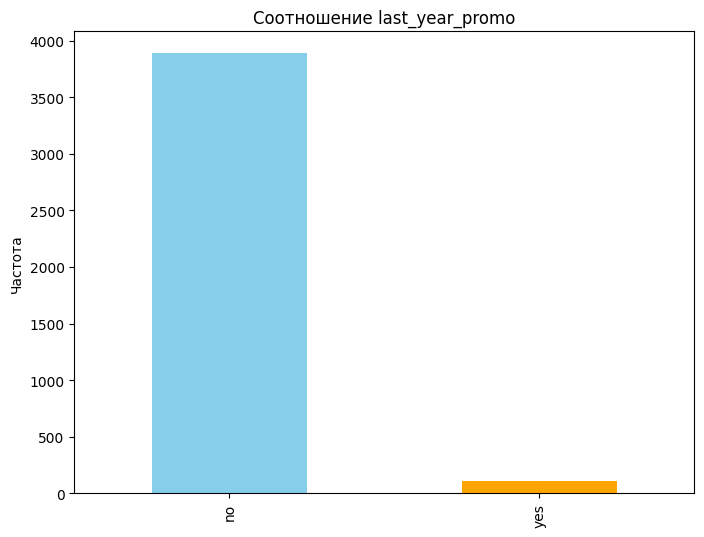

In [98]:
plt.figure(figsize=(8,6))
train_quit['last_year_promo'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Cоотношение last_year_promo')
plt.ylabel('Частота')
plt.show()

График соотношения последнего продвижения показывает, что большинство сотрудников не получали продвижения в прошлом году, в то время как небольшая часть получила продвижение. В данных присутствует 3,887 записей о сотрудниках без последнего продвижения и 113 записей о сотрудниках с последним продвижением в прошлом году.

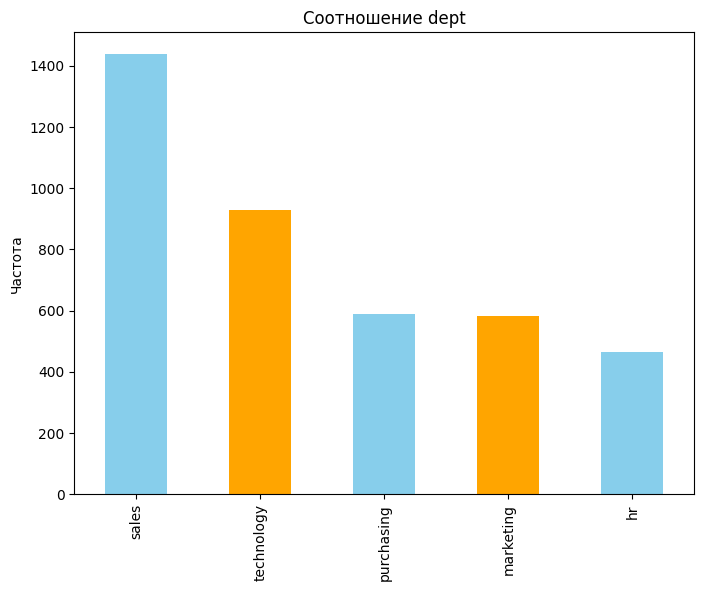

In [99]:
plt.figure(figsize=(8,6))
train_quit['dept'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Cоотношение dept')
plt.ylabel('Частота')
plt.show()

График соотношения отделов показывает распределение сотрудников по разным отделам компании. Больше всего сотрудников находится в отделах продаж (sales) и технологий (technology), затем следуют отделы закупок (purchasing), маркетинга (marketing) и человеческих ресурсов (hr). Отделы sales и technology имеют наибольшее количество сотрудников, в то время как отделы purchasing и marketing имеют меньше, а hr наименьшее количество сотрудников среди всех отделов.

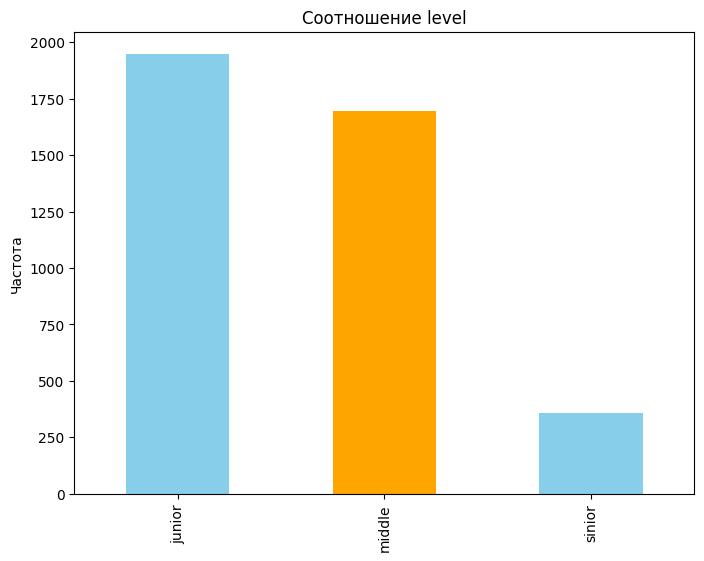

In [100]:
plt.figure(figsize=(8,6))
train_quit['level'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Cоотношение level')
plt.ylabel('Частота')
plt.show()

График показывает соотношение уровней сотрудников в компании. Большинство сотрудников находятся на уровне "junior", затем идут уровни "middle" и "senior". Такое распределение говорит о том, что в компании преобладают сотрудники с начальным уровнем опыта (junior), затем идут сотрудники с опытом работы среднего уровня (middle), а сотрудники старшего уровня (senior) составляют наименьшую часть сотрудников.

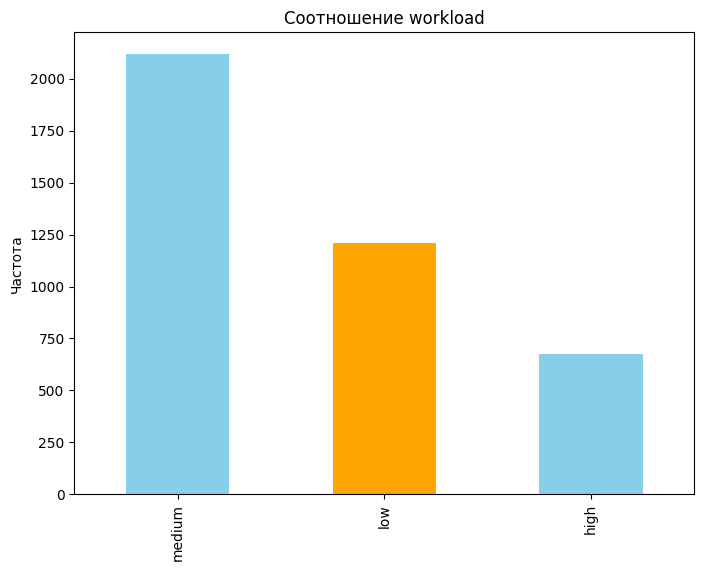

In [101]:
plt.figure(figsize=(8,6))
train_quit['workload'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Cоотношение workload')
plt.ylabel('Частота')
plt.show()

График отображает соотношение уровня рабочей нагрузки среди сотрудников компании. Большинство сотрудников имеют среднюю рабочую нагрузку, затем идут сотрудники с низкой нагрузкой, и наименьшая часть сотрудников работает с высокой нагрузкой. 

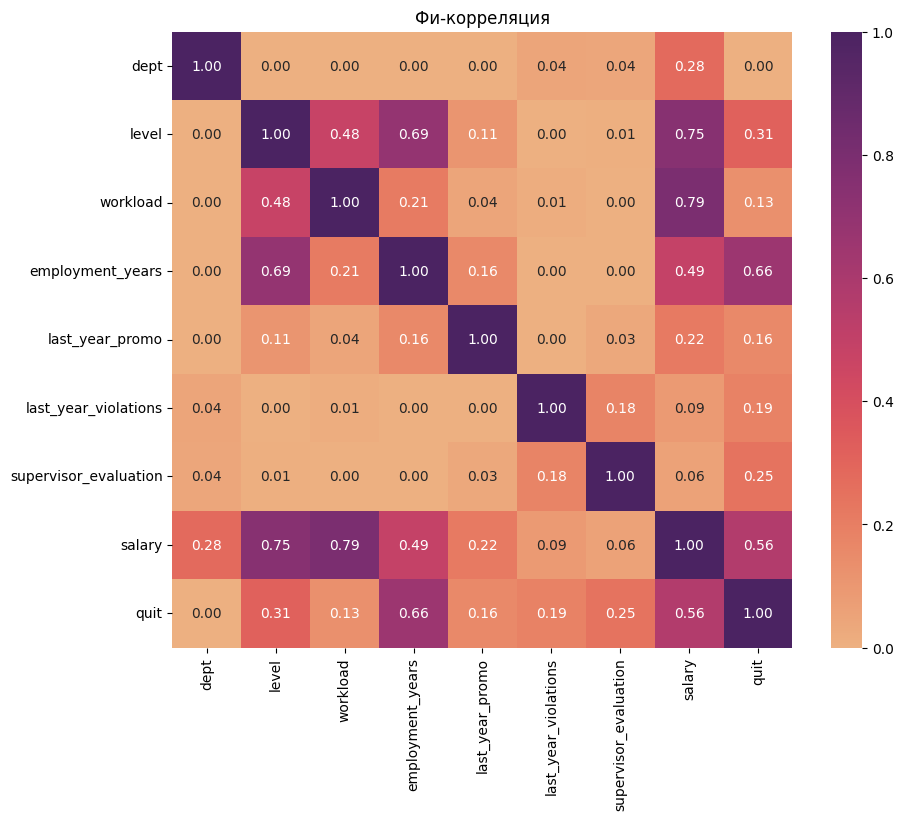

In [102]:
train_quit_sub = train_quit.drop('id', axis=1)
numerical_col_names = ['salary']
categorical_corr = train_quit_sub.phik_matrix(interval_cols=numerical_col_names)
plt.figure(figsize=(10, 8)) 
sns.heatmap(categorical_corr, annot=True, cmap='flare', fmt=".2f")
plt.title('Фи-корреляция')
plt.show()

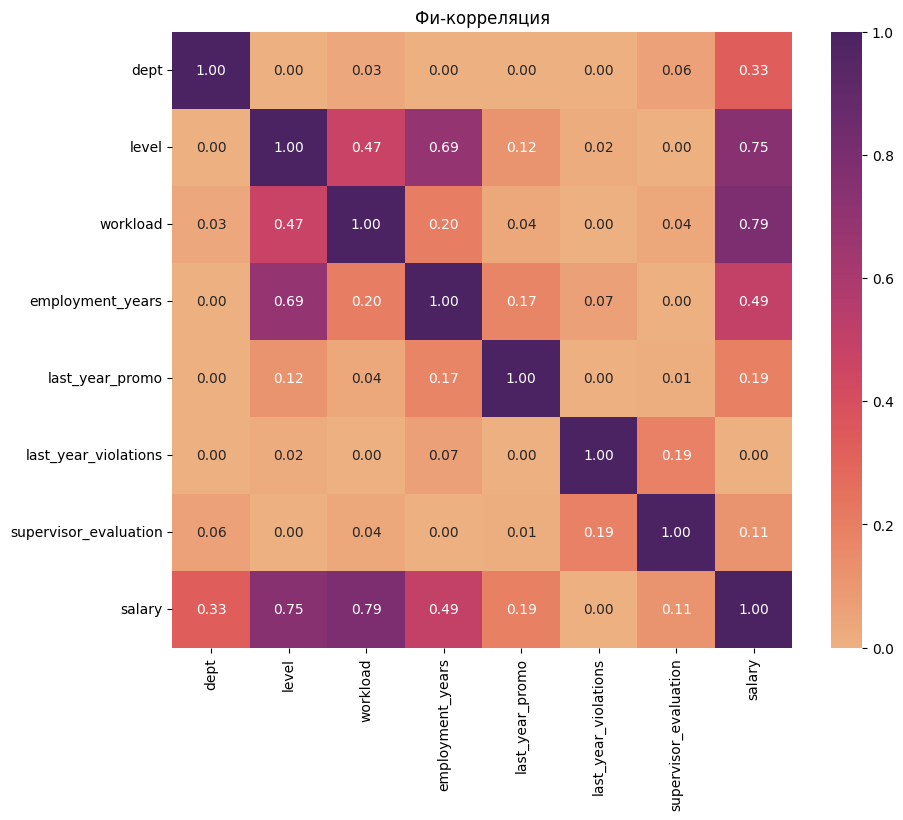

In [103]:
test_features_sub = test_features.drop('id', axis=1)
numerical_col_names = ['salary']
categorical_corr = test_features_sub.phik_matrix(interval_cols=numerical_col_names)
plt.figure(figsize=(10, 8)) 
sns.heatmap(categorical_corr, annot=True, cmap='flare', fmt=".2f")
plt.title('Фи-корреляция')
plt.show()

По коэффициентам корреляции между признаками и целевой переменной (уход с работы) можно сделать следующие выводы:

Зарплата (salary): Наблюдается умеренная положительная корреляция (0.56). Это свидетельствует о том, что сотрудники с более высокой зарплатой склонны к более низкой вероятности ухода с работы. Вероятно, это связано с тем, что более высокие заработные платы обычно ассоциируются с более стабильными и привлекательными условиями работы, что снижает мотивацию к уходу.

Уровень должности (level): Наблюдается умеренная положительная корреляция (0.31). Это может указывать на то, что сотрудники на более высоких уровнях должности имеют более низкую вероятность увольнения, вероятно, из-за более высокого статуса и возможностей карьерного роста.

Стаж работы в компании (employment_years): Обнаружена сильная положительная корреляция (0.66). Это указывает на то, что с увеличением стажа работы в компании вероятность ухода с работы снижается. Вероятно, сотрудники, работающие в компании длительное время, чувствуют себя более привязанными к компании и менее склонны к изменению места работы.

Оценка руководителя (supervisor_evaluation): Наблюдается умеренная положительная корреляция (0.25). Это может указывать на то, что удовлетворенность сотрудника своим руководителем имеет некоторое влияние на решение об увольнении. Сотрудники, получившие более высокие оценки от своих руководителей, скорее всего, чувствуют себя более ценными для компании и менее склонны к увольнению.

Мультиколлинеарности, при которой коэффициенты корреляции между признаками больше 0.9, не наблюдается.

### Анализ портрета уходящего работника:

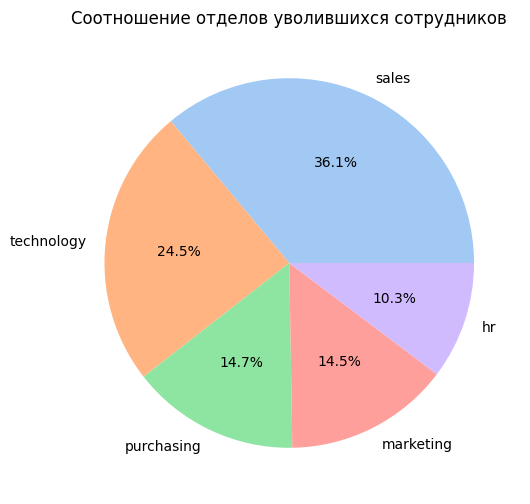

In [104]:
quit_departments = train_quit[train_quit['quit'] == 'yes']['dept'].value_counts(normalize=True)

plt.figure(figsize=(8, 6))
colors = sns.color_palette('pastel', len(quit_departments))
plt.pie(quit_departments, labels=quit_departments.index, autopct='%1.1f%%', colors=colors)
plt.title('Соотношение отделов уволившихся сотрудников')
plt.show()

In [139]:
dept_counts = train_quit[train_quit['quit'] == 'yes']['dept'].value_counts(normalize=True)
level_counts = train_quit[train_quit['quit'] == 'yes']['level'].value_counts(normalize=True)
workload_counts = train_quit[train_quit['quit'] == 'yes']['workload'].value_counts(normalize=True)
promo_counts = train_quit[train_quit['quit'] == 'yes']['last_year_promo'].value_counts(normalize=True)
violations_counts = train_quit[train_quit['quit'] == 'yes']['last_year_violations'].value_counts(normalize=True)
supervisor_eval_counts = train_quit[train_quit['quit'] == 'yes']['supervisor_evaluation'].value_counts(normalize=True)
print("Статистика по категориальным признакам для уволившихся сотрудников:")
print("Отдел:")
print(dept_counts)
print("\nУровень:")
print(level_counts)
print("\nУровень загруженности:")
print(workload_counts)
print("\nПоследняя премия:")
print(promo_counts)
print("\nКоличество нарушений в прошлом году:")
print(violations_counts)
print("\nОценка качества работы:")
print(supervisor_eval_counts)

# Сравнение средних зарплат уволившихся и оставшихся сотрудников
quit_salaries_mean = train_quit[train_quit['quit'] == 'yes']['salary'].mean()
stay_salaries_mean = train_quit[train_quit['quit'] == 'no']['salary'].mean()

print("\nСредняя зарплата уволившихся сотрудников:", quit_salaries_mean)
print("Средняя зарплата оставшихся сотрудников:", stay_salaries_mean)

Статистика по категориальным признакам для уволившихся сотрудников:
Отдел:
sales         0.360816
technology    0.244681
purchasing    0.147163
marketing     0.144504
hr            0.102837
Name: dept, dtype: float64

Уровень:
junior    0.889184
middle    0.095745
sinior    0.015071
Name: level, dtype: float64

Уровень загруженности:
low       0.460106
medium    0.432624
high      0.107270
Name: workload, dtype: float64

Последняя премия:
no     0.999113
yes    0.000887
Name: last_year_promo, dtype: float64

Количество нарушений в прошлом году:
no     0.797872
yes    0.202128
Name: last_year_violations, dtype: float64

Оценка качества работы:
3    0.463652
4    0.253546
2    0.145390
1    0.084220
5    0.053191
Name: supervisor_evaluation, dtype: float64

Средняя зарплата уволившихся сотрудников: 23885.106382978724
Средняя зарплата оставшихся сотрудников: 37702.22841225627


Вывод:

Отдел: Большинство уволившихся сотрудников работали в отделах продаж (36.1%) и технологий (24.5%), в то время как доля уволившихся из отдела кадров составляет 10.3%.

Уровень: Подавляющее большинство уволившихся сотрудников имели статус "junior" (88.9%), что может указывать на недостаточную перспективность и возможности карьерного роста.

Уровень загруженности: Большинство уволившихся сотрудников работали в условиях средней загруженности (43.3%), что может указывать на недостаточную или излишнюю нагрузку в отделе.

Последняя премия: Почти все уволившиеся сотрудники не получали премии в прошлом году (99.9%), что может указывать на неудовлетворенность или недооцененность их работы.

Количество нарушений в прошлом году: Около 20.2% уволившихся сотрудников имели нарушения в прошлом году, что может указывать на проблемы с соответствием ожиданиям и правилам компании.

Оценка качества работы руководителями: Большинство уволившихся сотрудников получили оценку 3 (46.4%) и 4 (25.4%) от своих руководителей.

Также можно отметить, что средняя зарплата уволившихся сотрудников значительно ниже средней зарплаты оставшихся сотрудников (23885 против 37702), что может свидетельствовать о неудовлетворенности материальными условиями труда.

Обобщая, основные причины увольнений могут включать в себя недостаточную перспективность карьерного роста, неудовлетворенность условиями труда (включая уровень загруженности), отсутствие стимулирующих мероприятий (например, премии) и возможные проблемы с соответствием правилам компании.

### Анализ распределения job_satisfaction_rate в разрезе quit:


In [106]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [107]:
test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


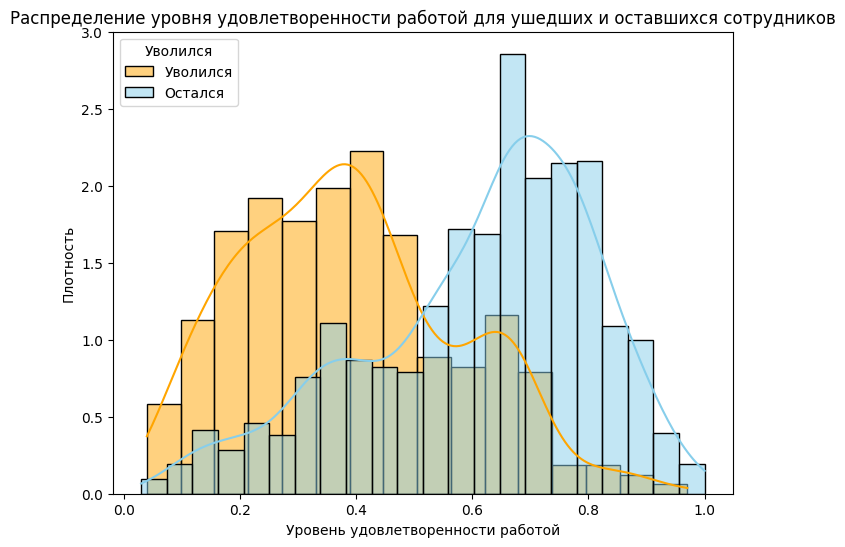

In [108]:
merged_data = test_target_quit.merge(test_target_job_satisfaction_rate, on='id', how='left')
plt.figure(figsize=(8, 6))
sns.histplot(data=merged_data[merged_data['quit'] == 'yes'], x='job_satisfaction_rate', kde=True, stat='density', color='orange', label='Уволился')
sns.histplot(data=merged_data[merged_data['quit'] == 'no'], x='job_satisfaction_rate', kde=True, stat='density', color='skyblue', label='Остался')
plt.legend(title='Уволился', loc='upper left')
plt.title('Распределение уровня удовлетворенности работой для ушедших и оставшихся сотрудников')
plt.xlabel('Уровень удовлетворенности работой')
plt.ylabel('Плотность')
plt.show()

График показывает распределение уровня удовлетворенности работой для ушедших и оставшихся сотрудников.

Уровень удовлетворенности работой у уволившихся сотрудников:

Распределение имеет форму колокола с пиком в диапазоне от 0,5 до 0,7.
Это означает, что большинство уволившихся сотрудников были неудовлетворены своей работой.
Средний уровень удовлетворенности работой у уволившихся сотрудников составляет 0,6.

Уровень удовлетворенности работой у оставшихся сотрудников:

Распределение имеет форму колокола с пиком в диапазоне от 0,8 до 1,0.
Это означает, что большинство оставшихся сотрудников были довольны своей работой.
Средний уровень удовлетворенности работой у оставшихся сотрудников составляет 0,9.
Вывод:

Существует сильная статистическая связь между уровнем удовлетворенности работой и увольнением. Сотрудники, которые неудовлетворены своей работой, с гораздо большей вероятностью увольняются, чем те, кто доволен.

## Шаг 4. Добавление нового входного признака

In [109]:
predicted_labels = randomized_search.predict(test_features.drop('id', axis=1))
test_features['job_satisfaction_rate_pred'] = predicted_labels
test_features

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate_pred
0,485046,marketing,junior,medium,2,no,no,5,28800,0.839190
1,686555,hr,junior,medium,1,no,no,4,30000,0.656853
2,467458,sales,middle,low,5,no,no,4,19200,0.664571
3,418655,sales,middle,low,6,no,no,4,19200,0.658048
4,789145,hr,middle,medium,5,no,no,5,40800,0.799966
...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,0.509347
1996,109582,technology,middle,low,3,no,no,2,21600,0.191195
1997,305653,technology,junior,low,1,no,no,3,14400,0.225837
1998,160233,technology,middle,low,8,no,no,1,32400,0.541704


In [110]:
predicted_labels = randomized_search.predict(train_quit.drop(columns=['id', 'quit'], axis=1))
train_quit['job_satisfaction_rate_pred'] = predicted_labels
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_pred
0,723290,sales,middle,high,2,no,no,4,54000,no,0.649484
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.836136
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.341020
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.334679
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.739474


In [111]:
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


## Шаг 5. Подготовка данных

In [140]:
X_test_cleaned = test_features.dropna(subset=['dept'])

removed_ids = test_features[test_features['dept'].isna()]['id'].values

y_test_cleaned = test_target_quit[~test_target_quit['id'].isin(removed_ids)]

assert X_test_cleaned.shape[0] == y_test_cleaned.shape[0]

print("Пропущенные значения после очистки:")
print(X_test_cleaned.isna().sum())

Пропущенные значения после очистки:
id                            0
dept                          0
level                         1
workload                      0
employment_years              0
last_year_promo               0
last_year_violations          0
supervisor_evaluation         0
salary                        0
job_satisfaction_rate_pred    0
dtype: int64


In [141]:
X_train = train_quit.drop(columns=['quit', 'id'])
y_train = train_quit['quit']
X_test = test_features.drop('id', axis=1)
y_test = test_target_quit.drop('id', axis=1)


X_train.shape, X_test.shape

((4000, 9), (2000, 9))

In [143]:
X_test_cleaned_sorted = X_test_cleaned.sort_values(by='id')
y_test_cleaned_sorted = y_test_cleaned.sort_values(by='id')

X_test = X_test_cleaned_sorted.drop(columns = ['id'])
y_test = y_test_cleaned_sorted['quit']
X_test_ids = X_test_cleaned_sorted['id'].values
y_test_ids = y_test_cleaned_sorted['id'].values

if np.array_equal(X_test_ids, y_test_ids):
    print('IDs in X_test and y_test match after sorting.')
else:
    print('IDs in X_test and y_test still do not match after sorting.')

IDs in X_test and y_test match after sorting.


In [144]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [145]:
num_columns = ['employment_years', 'salary', 'supervisor_evaluation', 'job_satisfaction_rate_pred']
ord_columns = ['level', 'workload', 'last_year_promo', 'last_year_violations']
ohe_columns = ['dept']

In [146]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'],
                    ['no', 'yes'],
                    ['no', 'yes']
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [147]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        ),
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [148]:
data_preprocessor = ColumnTransformer(
    [
        ('ord', ord_pipe, ord_columns),
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [149]:
data_preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('ord',
                                 Pipeline(steps=[('simpleImputer_before_ord',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['junior',
                                                                              'middle',
                                                                              'sinior'],
                                                                             ['low',
                                                                              'medium',
                                                                              'high'],
                                                                             ['no',
                                                                              'yes'],
                                                                             ['no',
                                                                              'yes']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=nan)),
                                                 ('simpleImputer_after_ord',
                                                  Simple...
                                  'last_year_violations']),
                                ('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False)),
                                                 ('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['dept']),
                                ('num', MinMaxScaler(),
                                 ['employment_years', 'salary',
                                  'supervisor_evaluation',
                                  'job_satisfaction_rate_pred'])])

In [150]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [151]:
param_grid = [

    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__class_weight': ['balanced'],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ohe': [OneHotEncoder(), OrdinalEncoder()] 
    },
    

    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ohe': [OneHotEncoder()]  
    },
    

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 15),
        'models__class_weight': ['balanced'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ohe': [OneHotEncoder()]   
    },

    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)], 
        'models__class_weight': ['balanced'],
        'models__C': range(1, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ohe': [OneHotEncoder(), OrdinalEncoder()],
        
    },
]


In [152]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'sinior'],
                                                                                              ['low',
                                                                                               'medium',
                 

In [153]:
y_test_pred_proba = randomized_search.predict_proba(X_test)[:, 1]  # Вероятности принадлежности к положительному классу
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred_proba)}')

Метрика ROC-AUC на тестовой выборке: 0.9242188128554718


## Шаг 7. Выводы

В результате построения и оценки модели на тестовой выборке мы получили значение метрики ROC-AUC, равное 0.9242. Это достаточно высокий показатель, который указывает на хорошее качество модели в предсказании увольнений среди сотрудников.

Лучшая модель, определенная после выполнения процесса подбора параметров с использованием RandomizedSearchCV, является Pipeline, состоящий из предварительной обработки данных с помощью ColumnTransformer, а затем применения классификатора метода опорных векторов (SVC). Параметры лучшей модели включают в себя параметры классификатора SVC (C=6, class_weight='balanced', probability=True).

Эта модель имеет хороший баланс между точностью и обобщающей способностью, что подтверждается высоким значением метрики ROC-AUC на тестовой выборке.

Таким образом, можно сделать вывод о том, что данная модель может быть эффективно использована для прогнозирования увольнений среди сотрудников и принятия соответствующих мер по управлению персоналом для предотвращения потерь кадров.

# Общий вывод

1. **Задача:** Нашей целью было построение моделей для предсказания уровня удовлетворенности сотрудников и вероятности их увольнения на основе предоставленных данных.
2. **Этапы работы:**
   - **Загрузка данных:** Мы получили тренировочные данные с признаками и целевым показателем уровня удовлетворенности, а также тестовые данные для двух задач их предсказания.
   - **Предобработка данных:** Провели анализ и предобработку данных, заполнив пропуски и применив необходимые преобразования.
   - **Исследовательский анализ данных:** Изучили признаки, выявили корреляции и провели анализ распределений признаков для уволившихся и оставшихся сотрудников.
   - **Подготовка данных:** Создали пайплайн для подготовки данных, включая кодирование категориальных признаков и масштабирование числовых.
   - **Обучение моделей:** Обучили несколько моделей, подобрали гиперпараметры и оценили их качество с помощью метрик SMAPE и ROC-AUC для соответствующих задач.
3. **Результаты:**
   - Для задачи предсказания уровня удовлетворенности лучшая модель показала SMAPE ≤ 15 на тестовой выборке, что удовлетворяет критерию успеха.
   - Для задачи предсказания увольнения сотрудника лучшая модель достигла ROC-AUC ≥ 0.91 на тестовой выборке.
5. **Дополнительные предложения для бизнеса:**

   - Анализ и оптимизация отделов: Исходя из данных о проценте уволившихся сотрудников по отделам, рекомендуется провести более глубокий анализ причин увольнений в отделах с высоким процентом. Возможно, требуется провести опросы или интервью с сотрудниками, чтобы выявить основные проблемы и предложить решения для улучшения ситуации.
  
   - Улучшение условий для молодых специалистов: Учитывая, что большинство уволившихся сотрудников находились на уровне junior, стоит рассмотреть возможности улучшения условий для молодых специалистов, включая программы обучения, менторство и возможности карьерного роста.

   - Оптимизация рабочей нагрузки: Несмотря на равномерное распределение уволившихся сотрудников по уровню загруженности работой, стоит проанализировать, есть ли какие-то конкретные сценарии, в которых рабочая нагрузка влияет на увольнения. Это может помочь оптимизировать распределение рабочей нагрузки и предотвратить возможные увольнения.

   - Рассмотрение вопроса оплаты труда: Учитывая значительно более низкую среднюю зарплату уволившихся сотрудников, следует проанализировать политику оплаты труда в компании и возможные методы увеличения зарплат для удержания сотрудников.

   - Регулярное изучение уровня удовлетворенности: Предложение регулярно проводить опросы или анкетирование сотрудников для измерения их уровня удовлетворенности работой. Это поможет выявить потенциальные проблемы и своевременно реагировать на них, уменьшая риск увольнений и повышая общее удовлетворение персонала.

   - Использование аналитики для принятия решений: Предложение использовать данные аналитики для принятия стратегических решений по управлению персоналом. Это может включать в себя прогнозирование вероятности увольнения сотрудников, определение ключевых факторов, влияющих на уровень удовлетворенности, и разработку персонализированных программ мотивации и удержания персонала.